In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels

In [59]:
df = pd.read_csv('data_all.csv', sep=';', usecols=['name', 'surname', 'sport', 'start', 'end', 'top', 'reps', 'impr'])
df['impr'] = df['impr'].map(lambda x: float(int(x[:-1])) / 100)
df['reps'] = df['reps'].map(lambda x: int(x[:-1]))
df.head()

,name,surname,sport,start,end,top,reps,impr
0,Lucie,Halakucová,softball,0.90,1.54,1.95,30,3.20
1,Eliska,Thompsonova,softball,0.68,1.99,2.60,91,4.54
2,Matyáš,Vágner,fotbal golman,0.98,2.14,2.43,45,3.16
3,Charlotte,Velichova,basketbal,1.14,1.61,1.96,18,3.37
4,Simon,Hrubec,hokej golman,0.52,2.16,2.58,88,5.72


### Distribuce zlepšení

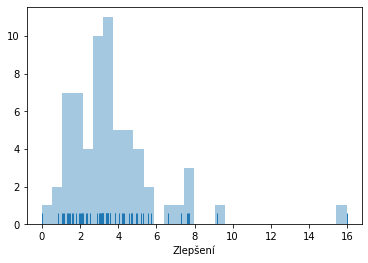

In [60]:
ax = sns.distplot(df['impr'], bins=30, kde=False, rug=True, label='Distribuce zlepšení',
             axlabel='Zlepšení')
ax.get_figure().savefig('zlepseni.png')


In [61]:
wcs = df['sport'].value_counts()
sports_filtered = df['sport'].map(lambda x:
                                  x if wcs.loc[x] >= 4
                                  else 'jiné')
df['sport_filtered'] = sports_filtered

### Zlepšili se ti, kdo to dělali víckrát?

Zdá se že spíš ne, ještě to otestujeme.

...

Pearsonův kor. koef. ovšem vychází 0,46 s p=hodnotou 0,0000913 (= pravděpodobnost,
že by nekorelovanné proměnné měly takovéhle vzorky).

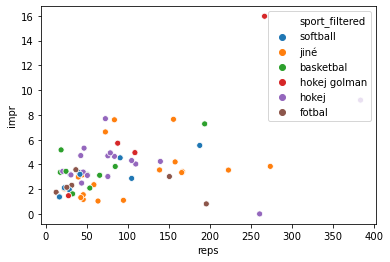

In [64]:
ax = sns.scatterplot(x=df['reps'], y=df['impr'], hue=df['sport_filtered'])
ax.get_figure().savefig('zlepseni_x_reps.png')
ax

In [62]:
scipy.stats.pearsonr(x=df['reps'], y=df['impr'])

(0.4660322986287076, 9.138917973563417e-05)